In [10]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Generated Sample Data with some test data with some missing values.

In [11]:
data = {'datetime': pd.date_range(start='1/15/2018', end='02/14/2018', freq='D')\
                .append(pd.date_range(start='1/15/2018', end='02/14/2018', freq='D')),
        'house' : ['house1' for i in range(31)] + ['house2' for i in range(31)],
        'readvalue':  [0.5 + 0.5*np.sin(2*np.pi/30*i) for i in range(31)]\
                    + [0.5 + 0.5*np.cos(2*np.pi/30*i) for i in range(31)]}
df0 = pd.DataFrame(data, columns = ['datetime', 'house', 'readvalue'])

# Randomly drop half the reads
random.seed(42)
df0 = df0.drop(random.sample(range(df0.shape[0]), k=int(df0.shape[0]/2)))

Generating a plot of the data with missing value

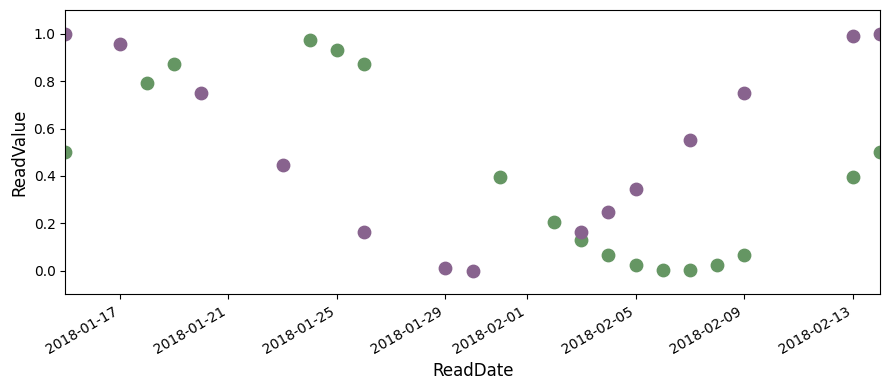

In [12]:
# Setting figure properties
params = {'legend.fontsize' : 'large',
         'figure.figsize': (9,4),
         'axes.labelsize': 'large',
         'xtick.labelsize': 'medium',
         'ytick.labelsize': 'medium'}
plt.rcParams.update(params)

# Generate colors using nices seaborn color palette
colors = {"house1": sns.color_palette("Set1", n_colors=8, desat=.5)[2],\
          "house2": sns.color_palette("Set1", n_colors=8, desat=.5)[3]}

fig, ax = plt.subplots()

for myhouse in ["house1", "house2"]:
    ax.scatter(pd.DatetimeIndex(df0[df0.house==myhouse]['datetime']),
               df0[df0.house==myhouse]['readvalue'],
               color=colors[myhouse],
               s=80)

ax.set_xlabel("ReadDate")
ax.set_ylabel("ReadValue")

# Format x-axis to properly displays dates
fig.autofmt_xdate()
ax.set_xlim(min(pd.DatetimeIndex(df0['datetime'])), max(pd.DatetimeIndex(df0['datetime'])))
ax.set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.savefig('interpolating-timeseries-p1-pandas-fig1.png')
plt.show()

Three different methods of interpolating the missing read values: forward-filling, backward-filling and 
interpolating. 

In [13]:
df = df0.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime']
del df['datetime']

Interpolation

Since we want to interpolate for each house separately, we need to group our data by 'house' 
before we can use the resample() function with the option 'D' to resample the data to daily frequency.

In [28]:
#ffill() - forward filling

df_pad = df.groupby('house')\
            .resample('D')\
            .ffill()\
            .drop('house', axis=1)


#bfill - backward filling

df_bfill = df.groupby('house')\
            .resample('D')\
            .bfill()\
            .drop('house', axis=1)

#interpolate() - interpolating

df_interpol = df.groupby('house')\
                .resample('D')\
                .mean()
df_interpol['readvalue'] = df_interpol['readvalue'].interpolate()

Visualizing the Results

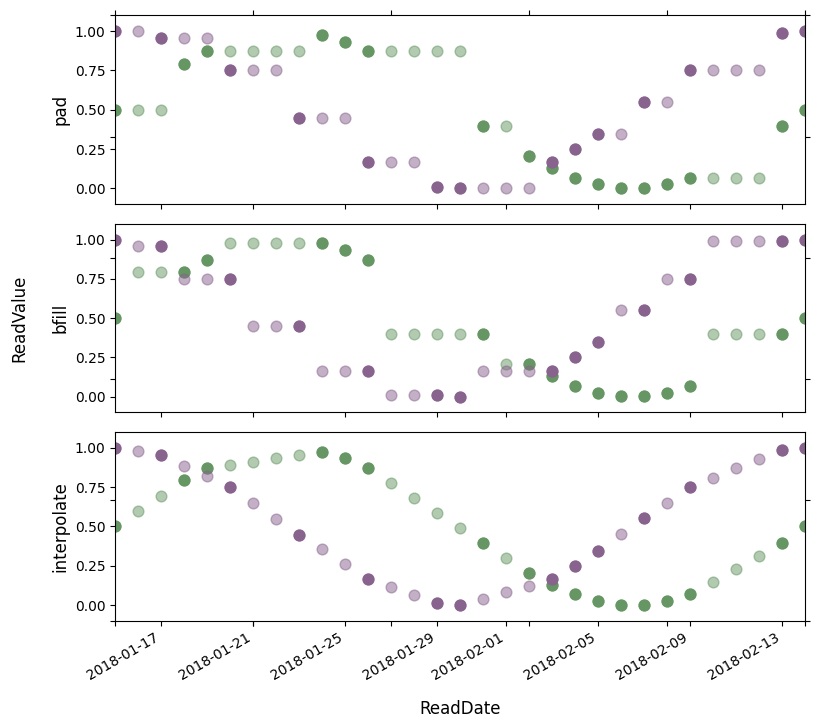

In [29]:
# Setting figure parameters
params = {'legend.fontsize' : 'large',
         'figure.figsize': (9,8),
         'axes.labelsize': 'large',
         'xtick.labelsize': 'medium',
         'ytick.labelsize': 'medium'}
plt.rcParams.update(params)

# Generate a list of dataframes to loop over
dfs = []
dfs.append(df_pad.reset_index())
dfs.append(df_bfill.reset_index())
dfs.append(df_interpol.reset_index())

ylabel = ['pad', 'bfill', 'interpolate']

n_df = len(dfs)
fig, ax = plt.subplots(n_df)

for myhouse in ["house1", "house2"]:

    for i in range(n_df):
        ax[i].scatter(pd.DatetimeIndex(dfs[i][dfs[i].house==myhouse]['datetime']), pd.to_numeric(dfs[i][dfs[i].house==myhouse]['readvalue']), color=colors[myhouse], s=60, alpha=0.5)
        ax[i].scatter(pd.DatetimeIndex(df0[df0.house==myhouse]['datetime']), pd.to_numeric(df0[df0.house==myhouse]['readvalue']), color=colors[myhouse], s=60)
        
        ax[i].set_xlim(min(pd.DatetimeIndex(df0['datetime'])), max(pd.DatetimeIndex(df0['datetime'])))
        ax[i].set_ylim([-0.1, 1.1])

fig.autofmt_xdate()

for i in range(n_df):
    ax[i].set_ylabel(ylabel[i])

# Adding another subplot in order to have common y-label
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the common axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel('ReadDate', labelpad=40)
plt.ylabel('ReadValue', labelpad=40)

plt.tight_layout()
plt.savefig('interpolating-timeseries-p1-pandas-fig2.png')
plt.show()
plt.close()